In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashion-product-images-dataset/fashion-dataset/images.csv
/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv
/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/31973.jpg
/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/30778.jpg
/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/19812.jpg
/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/22735.jpg
/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/38246.jpg
/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/16916.jpg
/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/52876.jpg
/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/39500.jpg
/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/44758.jpg
/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/59454.jpg
/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/44951.jp

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Using device: cuda
GPU: Tesla P100-PCIE-16GB
Memory: 15.89 GB


In [8]:
import os
os.makedirs('/kaggle/working/src', exist_ok=True)
os.makedirs('/kaggle/working/data', exist_ok=True)

In [9]:
!pip install albumentations opencv-python

In [68]:
%%writefile /kaggle/working/src/fashion_classifier.py
# Cell 3: Create fashion_classifier.py
# Cell 3: Create fashion_classifier.py
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pickle

class FashionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
            
        # Get the correct column names from the CSV
        baseColour = self.df.iloc[idx]['baseColour']
        articleType = self.df.iloc[idx]['articleType']
        season = self.df.iloc[idx]['season']
        gender = self.df.iloc[idx]['gender']
        
        return image, {
            'baseColour': baseColour,
            'articleType': articleType,
            'season': season,
            'gender': gender
        }

class FashionClassifier(nn.Module):
    def __init__(self, num_colors, num_product_types, num_seasons, num_genders):
        super(FashionClassifier, self).__init__()
        
        # Use ResNet50 as backbone
        self.backbone = models.resnet50(pretrained=True)
        num_features = self.backbone.fc.in_features
        
        # Remove the last fully connected layer
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
        
        # Task-specific heads
        self.color_head = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_colors)
        )
        
        self.articleType_head = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_product_types)
        )
        
        self.season_head = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_seasons)
        )
        
        self.gender_head = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_genders)
        )
        
    def forward(self, x):
        features = self.backbone(x)
        features = features.view(features.size(0), -1)
        
        baseColour_logits = self.color_head(features)
        articleType_logits = self.articleType_head(features)
        season_logits = self.season_head(features)
        gender_logits = self.gender_head(features)
        
        return {
            'baseColour': baseColour_logits,
            'articleType': articleType_logits,
            'season': season_logits,
            'gender': gender_logits
        }

def get_transforms():
    train_transform = A.Compose([
        A.Resize(224, 224),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    val_transform = A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    return train_transform, val_transform

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for images, targets in train_loader:
            images = images.to(device)
            
            # Move targets to device
            targets = {k: v.to(device) for k, v in targets.items()}
            
            optimizer.zero_grad()
            outputs = model(images)
            
            # Calculate loss for each task
            loss = 0
            for task in ['baseColour', 'articleType', 'season', 'gender']:
                loss += criterion(outputs[task], targets[task])
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for images, targets in val_loader:
                images = images.to(device)
                targets = {k: v.to(device) for k, v in targets.items()}
                
                outputs = model(images)
                
                loss = 0
                for task in ['baseColour', 'articleType', 'season', 'gender']:
                    loss += criterion(outputs[task], targets[task])
                
                val_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), '/kaggle/working/fashion_model.pth')

def predict_image(model, image_path, transform, device, label_encoders):
    model.eval()
    
    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    augmented = transform(image=image)
    image = augmented['image']
    image = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image)
    
    predictions = {}
    # Use the correct column names
    task_mapping = {
        'baseColour': 'baseColour',
        'articleType': 'articleType',
        'season': 'season',
        'gender': 'gender'
    }
    
    for model_task, data_task in task_mapping.items():
        pred = torch.argmax(outputs[model_task], dim=1).item()
        predictions[data_task] = label_encoders[data_task].inverse_transform([pred])[0]
    
    return predictions

Overwriting /kaggle/working/src/fashion_classifier.py


In [81]:
%%writefile /kaggle/working/src/train.py
# Cell 4: Create train.py
import os
import pandas as pd
import numpy as np
from tqdm import tqdm  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
import sys
import torch
from torch.utils.data import DataLoader

# Add the parent directory to Python path
sys.path.append('/kaggle/working')
from src.fashion_classifier import FashionDataset, FashionClassifier, get_transforms, train_model

def preprocess_data(data_dir):
    # Load the dataset with correct path and handle bad lines
    styles_df = pd.read_csv('/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv', on_bad_lines='skip')    
    
    # Create image paths with correct directory structure
    styles_df['image_path'] = styles_df['id'].apply(lambda x: os.path.join(data_dir, 'images', f'{x}.jpg'))
    
    # Filter out rows where image doesn't exist
    styles_df = styles_df[styles_df['image_path'].apply(os.path.exists)]
    
    # Create label encoders for each task with correct column names
    label_encoders = {}
    for column in ['baseColour', 'articleType', 'season', 'gender']:
        le = LabelEncoder()
        styles_df[column] = le.fit_transform(styles_df[column])
        label_encoders[column] = le
    
    # Save label encoders
    with open('/kaggle/working/label_encoders.pkl', 'wb') as f:
        pickle.dump(label_encoders, f)
    
    # Split data into train and validation sets
    train_df, val_df = train_test_split(styles_df, test_size=0.2, random_state=42)
    
    return train_df, val_df, label_encoders

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Data directory with correct path
    data_dir = '/kaggle/input/fashion-product-images-dataset/fashion-dataset'
    
    # Check if the directory exists
    if not os.path.exists(data_dir):
        print(f"Error: Data directory {data_dir} does not exist")
        # Try to find the correct path
        print("Available directories in /kaggle/input:")
        import subprocess
        subprocess.run(['ls', '-la', '/kaggle/input'])
        return
    
    # Check if styles.csv exists
    styles_path = os.path.join(data_dir, 'styles.csv')
    if not os.path.exists(styles_path):
        print(f"Error: styles.csv not found at {styles_path}")
        # Try to find the correct path
        print("Available files in data directory:")
        import subprocess
        subprocess.run(['ls', '-la', data_dir])
        return
    
    # Preprocess data
    print("Preprocessing data...")
    train_df, val_df, label_encoders = preprocess_data(data_dir)
    
    # Get transforms
    train_transform, val_transform = get_transforms()
    
    # Create datasets
    train_dataset = FashionDataset(train_df, train_transform)
    val_dataset = FashionDataset(val_df, val_transform)
    
    # Create dataloaders with Kaggle-optimized settings
    train_loader = DataLoader(
        train_dataset, 
        batch_size=64,  # Increased batch size for GPU
        shuffle=True, 
        num_workers=4,
        pin_memory=True  # Enable pin_memory for faster data transfer to GPU
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=64,  # Increased batch size for GPU
        shuffle=False, 
        num_workers=4,
        pin_memory=True
    )
    
    # Initialize model with correct column names
    print("Initializing model...")
    model = FashionClassifier(
        num_colors=len(label_encoders['baseColour'].classes_),
        num_product_types=len(label_encoders['articleType'].classes_),
        num_seasons=len(label_encoders['season'].classes_),
        num_genders=len(label_encoders['gender'].classes_)
    ).to(device)
    
    # Define loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Define learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    
    # Early stopping
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0
    
    # Train model
    print("Starting training...")
    num_epochs = 15  # Increased number of epochs
    
    for epoch in range(num_epochs):
        # Training loop
        model.train()
        train_loss = 0.0
        for images, targets in train_loader:
            images = images.to(device)
            targets = {k: v.to(device) for k, v in targets.items()}
            
            optimizer.zero_grad()
            outputs = model(images)
            
            loss = 0
            for task in ['baseColour', 'articleType', 'season', 'gender']:
                loss += criterion(outputs[task], targets[task])
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, targets in val_loader:
                images = images.to(device)
                targets = {k: v.to(device) for k, v in targets.items()}
                
                outputs = model(images)
                
                loss = 0
                for task in ['baseColour', 'articleType', 'season', 'gender']:
                    loss += criterion(outputs[task], targets[task])
                
                val_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), '/kaggle/working/fashion_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break
    
    print("Training completed!")

if __name__ == "__main__":
    main()

Overwriting /kaggle/working/src/train.py


In [83]:
%cd /kaggle/working
!python src/train.py

/kaggle/working
/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
Using device: cuda
Preprocessing data...
Initializing model...
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weight

In [98]:
%%writefile /kaggle/working/src/predict.py
# Cell 5: Create predict.py

# Cell 5: Create predict.py
import os
import torch
import cv2
import pickle
import sys
import matplotlib.pyplot as plt

# Add the parent directory to Python path
sys.path.append('/kaggle/working')
from src.fashion_classifier import FashionClassifier, get_transforms

def load_model_and_encoders(model_path, encoders_path):
    # Load label encoders
    with open(encoders_path, 'rb') as f:
        label_encoders = pickle.load(f)
    
    # Initialize model with correct column names
    model = FashionClassifier(
        num_colors=len(label_encoders['baseColour'].classes_),
        num_product_types=len(label_encoders['articleType'].classes_),
        num_seasons=len(label_encoders['season'].classes_),
        num_genders=len(label_encoders['gender'].classes_)
    )
    
    # Load model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    return model, label_encoders

def predict_image(model, image_path, transform, device, label_encoders):
    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Apply transforms
    augmented = transform(image=image)
    image = augmented['image']
    image = image.unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(image)
    
    # Get predictions with correct column names
    predictions = {}
    task_mapping = {
        'baseColour': 'baseColour',
        'articleType': 'articleType',
        'season': 'season',
        'gender': 'gender'
    }
    
    for model_task, data_task in task_mapping.items():
        pred = torch.argmax(outputs[model_task], dim=1).item()
        predictions[data_task] = label_encoders[data_task].inverse_transform([pred])[0]
    
    return predictions, image

def display_prediction(image_path, predictions):
    # Load and display image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    
    # Add prediction text with correct column names
    prediction_text = f"Base Color: {predictions['baseColour']}\\n"
    prediction_text += f"Article Type: {predictions['articleType']}\\n"
    prediction_text += f"Season: {predictions['season']}\\n"
    prediction_text += f"Gender: {predictions['gender']}"
    
    plt.text(10, 30, prediction_text, 
             bbox=dict(facecolor='white', alpha=0.8),
             fontsize=12)
    
    # Save the plot instead of showing it in Kaggle
    plt.savefig('/kaggle/working/prediction_result.png')
    plt.close()

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load model and encoders - Kaggle specific paths
    model_path = '/kaggle/working/fashion_model.pth'
    encoders_path = '/kaggle/working/label_encoders.pkl'
    
    if not os.path.exists(model_path) or not os.path.exists(encoders_path):
        print("Error: Model or encoders not found. Please train the model first.")
        return
    
    model, label_encoders = load_model_and_encoders(model_path, encoders_path)
    model = model.to(device)
    
    # Get transforms
    _, val_transform = get_transforms()
    
    # Example prediction - using a test image from the dataset with correct path
    test_image_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/10020.jpg'
    if os.path.exists(test_image_path):
        predictions, _ = predict_image(model, test_image_path, val_transform, device, label_encoders)
        display_prediction(test_image_path, predictions)
        print("Predictions saved to /kaggle/working/prediction_result.png")
    else:
        print(f"Error: Test image not found at {test_image_path}")

if __name__ == "__main__":
    main()

Overwriting /kaggle/working/src/predict.py


In [99]:
!python /kaggle/working/src/predict.py

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
Using device: cuda
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/kaggle/working/src/predict.py:29: F

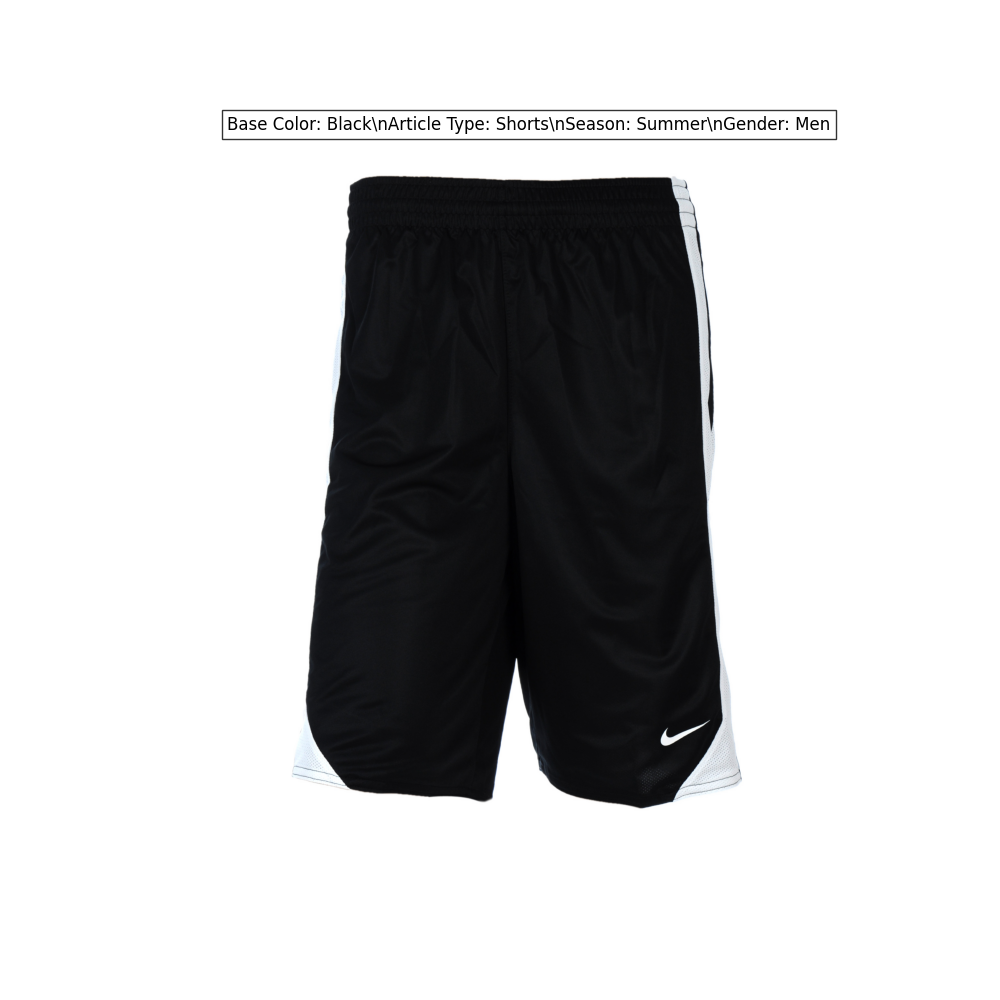

In [100]:
from IPython.display import Image
Image(filename='/kaggle/working/prediction_result.png')